<a href="https://colab.research.google.com/github/dangji1980/JSCEAI/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIプログラムを構築してみよう
土木学会学会誌２０２１年1月号
サンプルコードと解説
テーマ：
「さあ，ＡＩを始めよう」
～土木工学へのAI導入のススメ～
AI入門講座（2）
～AIプログラムを構築してみよう～
埼玉大学　党紀


# （０）説明
AIプログラムを構築するための知識を説明するために、一例として、畳み込みニューラルネットワークCNNで、画像分類問題を説明していきたいと思います。

使用モデル:CNN, ResNet

学習用データ:腐食とひび割れ分類

おおむね3つの部分で構成します：（１）準備、（２）訓練、（３）予測



#（１）準備
まずは環境設定、疑似環境を作る必要がないのですが：

1. 「ランタイム」メニュから「ランタイムのタイプを変更」を選択し、ハードウェアアクセラレーターをGPUと選択。最後に「保存」を押してください。

本サンプルをテストしてみる場合は下のセル実行は不要。

グーグルアカウントを持ち、かつマイドライブにデータを保存したい場合：
2.   グーグルドライブとつなぐ（マウント）下記のセールのコードを実施し，あらわされたリンクをクリックして、グーグルアカウントでログインしてください。その後現れたコードをコーヒーして、このページに戻り、下の空欄に貼り付けて「Enter」キーを押して実施。
3.　下記のセールの後半では，作業フォルダを設定します。このファイルもグーグルドライブのColab Notebooks/CNNというフォルダに置いてください。   





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('./drive/My Drive/Colab Notebooks/CNN/')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cat.jpg		     elephant.jpg	   mymodel_weights_final.h5
cnn.ipynb	     __MACOSX		   mymodel_weights.h5
confutionmatrix.jpg  mnist_mlp_model.json  transferlearning.png
data		     model.png		   val_acc.jpg


##手持ちデータV.Sデモ用データ
###マイデータを使う
訓練用データをグーグルドライブの工作用フォルダにいれてください。
Picsというフォルダにいれてください。
###デモしてみる
デモのためにここではダウンロードコードを書いております、下記のセールを実施することで自動的にデータがダウンロードされる。
自分のPCでJupyter Notebookで本ファイルを実施する場合下記のリンクからダウンロードしてください。
https://drive.google.com/file/d/1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k/view?usp=sharing


In [ ]:
from google_drive_downloader import GoogleDriveDownloader
# Pics.zip: Corrosion and Crack detection
#https://drive.google.com/file/d/1m6SPFcX01OKAENjltBOfDY9sGm3RhjSV/view?usp=sharing
# data.zip: Corrosion Ranking Data: A,B,C
#https://drive.google.com/file/d/1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k/view?usp=sharing
GoogleDriveDownloader.download_file_from_google_drive(file_id='1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k',
                                                      dest_path="./data.zip",
                                                      unzip=True)
!rm data.zip        
!ls

Unzipping...Done.
cnn.ipynb  data  __MACOSX


＃ライブラリの導入

In [ ]:
# ライブラリ導入
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Conv2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import plot_model
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import os

フォルダの設定です、マイデータの場合ほかのフォルダ名にしてください、デモの場合そのまま実施してください。

In [ ]:
## 使用したいデータのフォルダを指名してください。
!ls
foldername="data"
#Pics , data

cat.jpg		     elephant.jpg	   mymodel_weights_final.h5
cnn.ipynb	     __MACOSX		   mymodel_weights.h5
confutionmatrix.jpg  mnist_mlp_model.json  transferlearning.png
data		     model.png		   val_acc.jpg


データの情報を確認します。“data”の中に腐食分類問題として、「A」,「B」,「C」３ランクの写真がそれぞれ「A」,「B」,「C」のフォルダに収納しています。

フォルダ名をそれぞれクラス名として使われます。



In [ ]:
def listdir_nohidden(path): #macでは.ds_dataなど見えないフォルダが存在するので、ここで除去
    filelist=[]
    for f in os.listdir(path):
        if not f.startswith('.'):
            filelist.append(f)
    return filelist

folder = listdir_nohidden(foldername)
folder=sorted(folder)
name_classes=folder
num_classes=len(folder)
image_size = 224
dense_size  = len(name_classes)
print(folder)
#['A', 'B', 'C'] が下に現れたら、フォルダは正しく認識されている。

['A', 'B', 'C']


##データの導入とをデータの可視化
データを読み込んで、それぞれ訓練用とテスト用に分ける。

この辺りは少し時間がかかる場合がある。

実施されることを待ちましょう。

./data/A/A_Class_4.jpg
./data/A/A_Class_103.jpg
./data/A/A_Class_117.jpg
./data/A/A_Class_95.jpg
./data/A/A_Class_81.jpg
./data/A/A_Class_56.jpg
./data/A/A_Class_42.jpg
./data/A/A_Class_43.jpg
./data/A/A_Class_57.jpg
./data/A/A_Class_80.jpg
./data/A/A_Class_94.jpg
./data/A/A_Class_116.jpg
./data/A/A_Class_102.jpg
./data/A/A_Class_5.jpg
./data/A/A_Class_7.jpg
./data/A/A_Class_128.jpg
./data/A/A_Class_114.jpg
./data/A/A_Class_100.jpg
./data/A/A_Class_82.jpg
./data/A/A_Class_96.jpg
./data/A/A_Class_41.jpg
./data/A/A_Class_55.jpg
./data/A/A_Class_69.jpg
./data/A/A_Class_68.jpg
./data/A/A_Class_54.jpg
./data/A/A_Class_40.jpg
./data/A/A_Class_97.jpg
./data/A/A_Class_83.jpg
./data/A/A_Class_101.jpg
./data/A/A_Class_115.jpg
./data/A/A_Class_129.jpg
./data/A/A_Class_6.jpg
./data/A/A_Class_2.jpg
./data/A/A_Class_111.jpg
./data/A/A_Class_105.jpg
./data/A/A_Class_139.jpg
./data/A/A_Class_87.jpg
./data/A/A_Class_93.jpg
./data/A/A_Class_78.jpg
./data/A/A_Class_44.jpg
./data/A/A_Class_50.jpg
./data/A

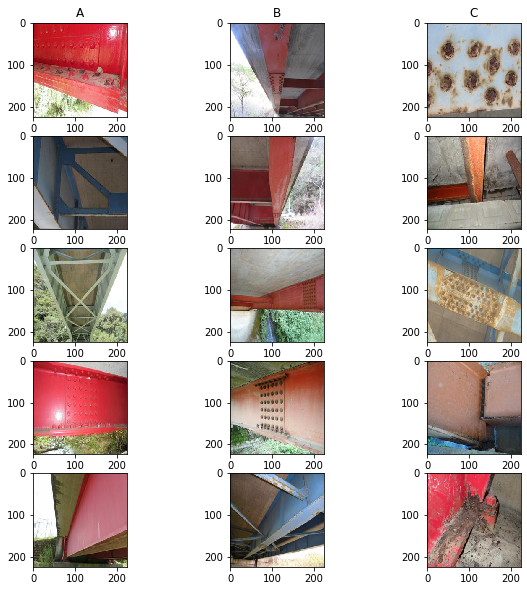

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # 図面のサイズを指定
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
X = []#入力データのリスト
Y = []#出力ラベルのリスト
samples_per_class=5
for index, classname in enumerate(folder): #enumerate番号と配列を同時取得
    dir = "./"+foldername+"/" + classname
    print("loading:",dir)
    files = glob.glob(dir + "/*.jpg")
    pickedfiles = np.random.choice(files, samples_per_class, replace=False)
    pickedfiles=sorted(pickedfiles)
    #print(classname,pickedfiles)
    iclass=0

    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
        if file in pickedfiles:
            plt_idx = iclass * num_classes + index + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            if iclass == 0:
                plt.title(classname)
            plt.imshow(data)
            iclass+=1
    

X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0

Y = np_utils.to_categorical(Y, dense_size)#kerasの小道具箱np_utilsを活用
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10) #sklearnを活用

# （２）訓練
これで下準備は完了ですので、訓練の段階に入ります。

まずはモデルを構築します。このデモではkerasを使います。既存のモデルならvgg16などは直接引用することもできます。一行で済みますね。

model=keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

ここでは中身を示すために０から構築していきます。

ほかのデモはkerasのhpからも解説などがあります。

https://keras.io/ja/applications/


## Resnetを使ってみる

###モデルを導入する
まず、既存のモデルの利用方法を説明する。

ここではResNetの例を説明するが、他にInceptionV3, VGG16などたくさんの既存モデルが直接利用できる。

Xception	88 MB	0.790	
VGG16	528 MB	0.715	
VGG19	549 MB	0.727	
ResNet50	99 MB	0.759	
InceptionV3	92 MB	0.788	
InceptionResNetV2	215 MB	0.804        
MobileNet	17 MB	0.665	
DenseNet121	33 MB	0.745	
DenseNet169	57 MB	0.759	
DenseNet201	80 MB	0.770

トップ1とトップ5の精度はImageNetの検証データセットを参照しています．

ResNetをまずkerasから導入する。

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
model = ResNet50(weights='imagenet')


102973440/102967424 [==============================] - 4s 0us/step


###モデルを使ってみる

Unzipping...Done.


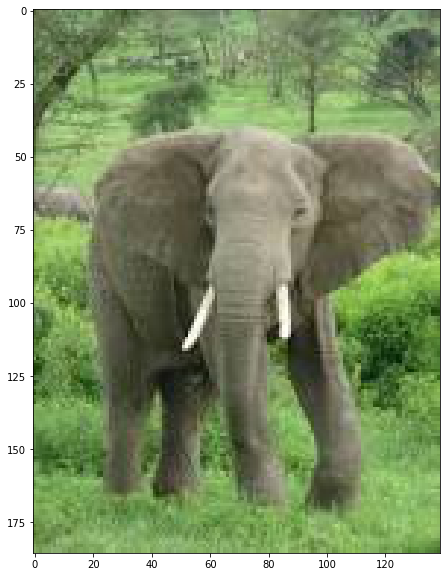

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.5790134), ('n01871265', 'tusker', 0.33651444), ('n02504013', 'Indian_elephant', 0.084472135)]


In [ ]:
#何かの写真ダウンロードしておく
imgname= 'elephant.jpg'
#例えば象の写真下記のリンクから直接ダウンロードすることもできる。
#https://drive.google.com/file/d/1sLApKnnYWTzil24jJt2KuKJbb3DSQ1dd/view?usp=sharing
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1Vb989Nq0sgi7RI7CUXiSzr1KIcbLZ7k7',
                                                      dest_path="./e.zip",
                                                      unzip=True)
!rm e.zip

def predict_one(img_path = 'elephant.jpg'):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('Predicted:', decode_predictions(preds, top=3)[0])
    # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
predict_one(img_path =imgname)


## 移転学習してみる

### モデル構成
まずは、既存モデルをベースにしてNN部分だけ作る

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


94773248/94765736 [==============================] - 4s 0us/step


###移転学習の訓練


移転学習とは訓練済みモデルの重みのほとんどを使い、一部のみの重みだけで訓練する方法で、少ないデータと訓練時間でいい精度を得られる方法である。


In [11]:
#　まず基礎モデルの重みを凍結する。
#すると、浅いヘッド層（NNの部分, DenseNet, 全結合層）だけ訓練される。
for layer in base_model.layers:
    layer.trainable = False

# モデルの訓練方法など設定（コンパイル）
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
epochs = 100  # 300?
# モデルを少し訓練する。ほんとは100~300エポックぐらい訓練して欲しい
history=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
model.save_weights('mymodel_weights.h5')

Epoch 1/100
20/20 [==============================] - 7s 343ms/step - loss: 1.8868 - accuracy: 0.3722 - val_loss: 1.0783 - val_accuracy: 0.3714
Epoch 2/100
20/20 [==============================] - 5s 239ms/step - loss: 1.3814 - accuracy: 0.3706 - val_loss: 1.5194 - val_accuracy: 0.4143
Epoch 3/100
20/20 [==============================] - 5s 238ms/step - loss: 1.3194 - accuracy: 0.3722 - val_loss: 1.8443 - val_accuracy: 0.4143
Epoch 4/100
20/20 [==============================] - 5s 237ms/step - loss: 1.2959 - accuracy: 0.3530 - val_loss: 1.3031 - val_accuracy: 0.4143
Epoch 5/100
20/20 [==============================] - 5s 237ms/step - loss: 1.2865 - accuracy: 0.3530 - val_loss: 1.1285 - val_accuracy: 0.4143
Epoch 6/100
20/20 [==============================] - 5s 236ms/step - loss: 1.1565 - accuracy: 0.3786 - val_loss: 1.7145 - val_accuracy: 0.2429
Epoch 7/100
20/20 [==============================] - 5s 237ms/step - loss: 1.1976 - accuracy: 0.3482 - val_loss: 1.1150 - val_accuracy: 0.4286

訓練結果可視化

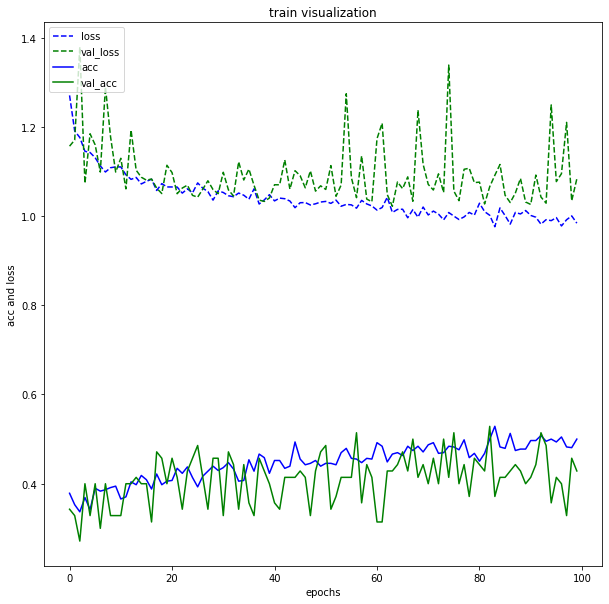

<Figure size 720x720 with 0 Axes>

In [ ]:
def visualizeHistory(history,name='train.png'):
    #訓練及び検証データの誤差と精度
    plt.plot(history.history['loss'],color='blue',label='loss',linestyle = "dashed")
    plt.plot(history.history['val_loss'],color='green',label='val_loss',linestyle = "dashed")
    plt.plot(history.history['accuracy'],color='blue',label='acc')
    plt.plot(history.history['val_accuracy'],color='green',label='val_acc')
    plt.title('train visualization')
    plt.ylabel('acc and loss')
    plt.xlabel('epochs')
    plt.legend( loc='upper left')
    plt.show()
    plt.savefig(name, bbox_inches='tight')
    return None
visualizeHistory(history,'transferlearning.png')

### 仕上げしてあげようFune Tuning


In [ ]:
#plot_model(model, to_file='model.png')
for i,layer in enumerate(model.layers):
    print("layer:%d"%i,layer.name)


層番号を見てみるとconv5まできりがいいので143何まで開放してあげよう

In [ ]:
num_free_layer=143
for layer in model.layers[:num_free_layer]:
   layer.trainable = False
for layer in model.layers[num_free_layer:]:
   layer.trainable = True


それとも大変時間がかかるからepoch数は控えめに

In [ ]:
epochs = 30  # 300?
# train the model on the new data for a few epochs
history=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)

model.save_weights('mymodel_weights_final.h5')
#結果の可視化
visualizeHistory(history)

### 合わせて書く

In [ ]:
#合わせて書く

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#Stage 01
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
epochs = 300  # 300?
# train the model on the new data for a few epochs
history1=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
#結果の可視化
visualizeHistory(history1,'transferlearning.png')

#Stage 02
num_free_layer=143
for layer in model.layers[:num_free_layer]:
   layer.trainable = False
for layer in model.layers[num_free_layer:]:
   layer.trainable = True

epochs = 100  # 300?
# train the model on the new data for a few epochs
history2=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
model.save_weights('mymodel_weights_final.h5')
#結果の可視化
visualizeHistory(history2,'finetuning.png')

In [ ]:

visualizeHistory(history2,'finetuing.png')

#（３）テストしてみる


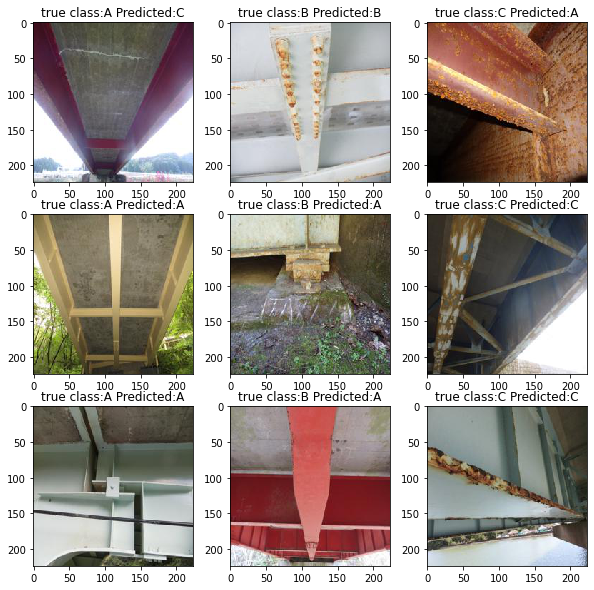

In [ ]:
def testvisualization(samples_per_class=3):
    for y, cls in enumerate(folder): #enumerate番号と配列を同時取得
        dir = "./"+foldername+"/" + cls
        files = glob.glob(dir + "/*.jpg")
        picedfiles = np.random.choice(files, samples_per_class, replace=False)
        for i, file in enumerate(picedfiles):
            img = image.load_img(file, target_size=(224, 224))
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(img)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            preds = model.predict(x)
            s="true class:"+cls+" Predicted:"+name_classes[preds[0].argmax()]        
            plt.title(s)
    plt.show()  
testvisualization(3)

## そのた：自作モデルの場合

In [ ]:
def CnnModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_size))
    model.add(Activation('softmax'))

    model.summary()
    return model

自作モデルの中身を覗いてみよう

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

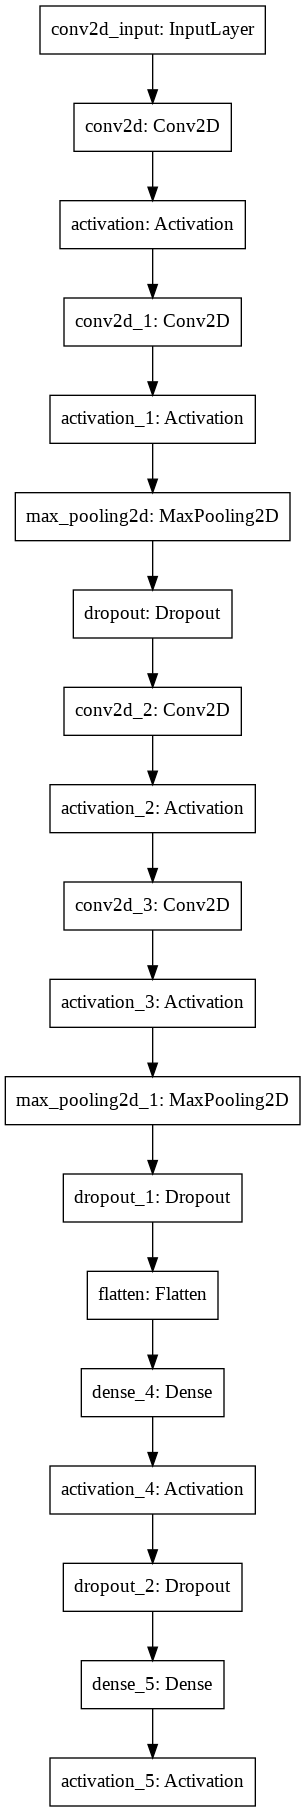

In [ ]:
model=CnnModel()

plot_model(model, to_file='model.png')


いざ直接訓練する（画像データ数が足りないため、過学習しがちのやり方ですが、デモのためにあえて実施してみる）

In [ ]:

#optimizers ="Adadelta"#hyperparameters:SGD, Adagrad, Adam, Adamax, RMSprop, Nadam
optimizers=Adam(lr=0.0001)
#SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
epochs = 30     # using 100 or 200?
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])
history= model.fit(X_train, y_train, validation_split=0.1, epochs=epochs )#<-training
model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mymodel_weights.h5')

Epoch 1/30
20/20 [==============================] - 3s 159ms/step - loss: 1.5009 - accuracy: 0.3307 - val_loss: 1.0936 - val_accuracy: 0.4000
Epoch 2/30
20/20 [==============================] - 3s 127ms/step - loss: 1.1041 - accuracy: 0.3658 - val_loss: 1.0983 - val_accuracy: 0.3571
Epoch 3/30
20/20 [==============================] - 3s 127ms/step - loss: 1.0853 - accuracy: 0.4089 - val_loss: 1.0910 - val_accuracy: 0.4143
Epoch 4/30
20/20 [==============================] - 3s 127ms/step - loss: 1.0680 - accuracy: 0.4489 - val_loss: 1.0665 - val_accuracy: 0.4429
Epoch 5/30
20/20 [==============================] - 3s 128ms/step - loss: 1.0360 - accuracy: 0.4776 - val_loss: 1.0472 - val_accuracy: 0.3857
Epoch 6/30
20/20 [==============================] - 3s 129ms/step - loss: 1.0202 - accuracy: 0.4952 - val_loss: 1.0274 - val_accuracy: 0.3857
Epoch 7/30
20/20 [==============================] - 3s 129ms/step - loss: 0.9799 - accuracy: 0.5224 - val_loss: 1.0056 - val_accuracy: 0.4429
Epoch 

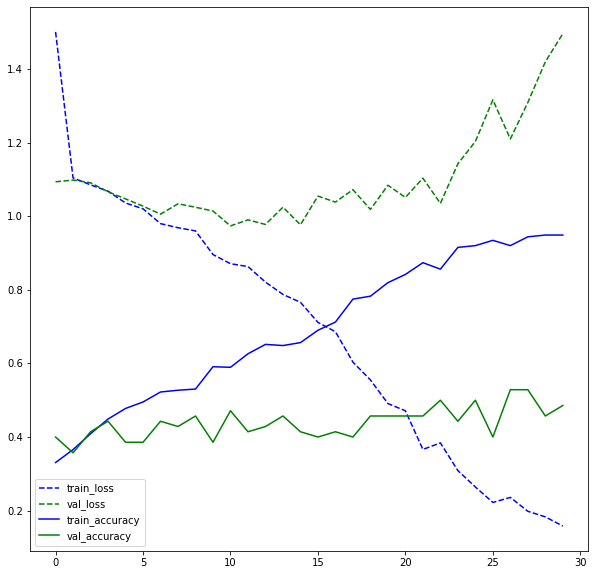

In [ ]:
visualizeHistory(history)

以上のように過学習してしまい、精度は上がりませんでした。
## グループテスト検証
テストデータを用いて、モデルの精度を検証する。

In [ ]:
#reference:https://medium.com/@manasnarkar/image-classification-with-convolution-neural-networks-cnn-with-keras-dbd71c05ed2a
test_loss, test_acc = model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 88ms/step - loss: 1.3242 - accuracy: 0.6154


## 混同行列を描く

Confusion matrix, without normalization
[[ 9  2  2]
 [ 7  7 11]
 [ 0  8 32]]


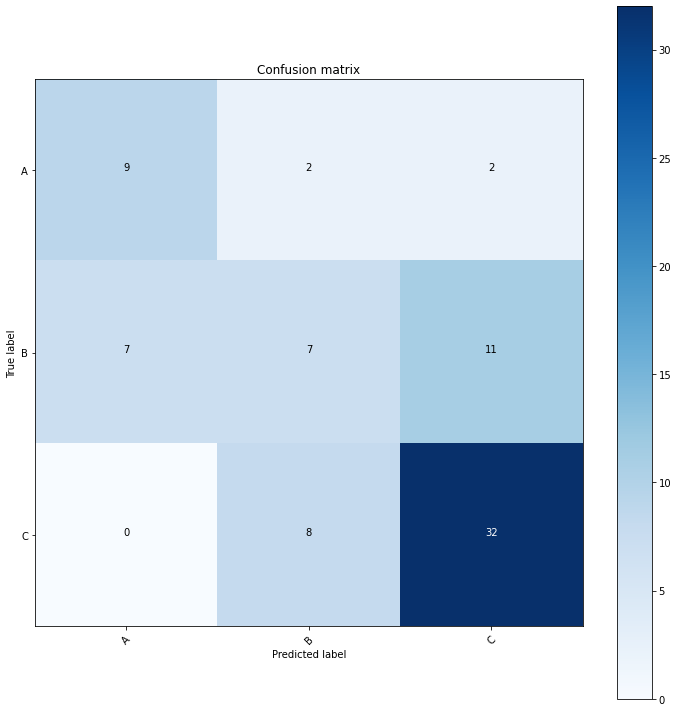

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confutionmatrix.jpg')


pred_y = model.predict(X_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = folder) 

# reference:http://kinpatucom821.hatenablog.com/entry/2018/08/30/215419

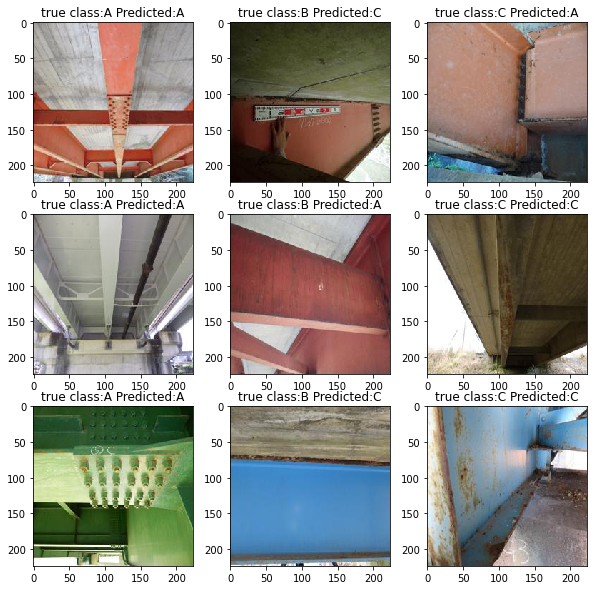

In [ ]:
# テストの可視化、前に定義した関数を使うだけ
testvisualization(3)